**Introduccion**


La energía fotovoltaica, desafia la modulacion precisa del comportamiento de celulas y modulos que son esenciales para optimizar el rendimiento de sistemas solares. Entre los muchos modelos matemáticos propuestos, el modelo basado en diodos se destaca por su eficacia y precicion. Este se enfoca en su fundamento de semiconductor de los materiales que componen las células fotovoltaicas, cuyas caracteristicas muestran un comportamiento exponencial como se ve en la curva I-V de un diodo. Un modelo muy utilizado es el Modelo de Diodo Único (SDM), gracias a su simplicidad y eficiencia. En este modelo, diversos elementos, como la fuente de corriente, el diodo que refleja los efectos físicos en la unión p-n, y las resistencias que modelan pérdidas ohmicas, se combinan de manera ingeniosa para proporcionar una representacion precisa del sistema fotovoltaico. La estimación precisa de los parametros desconocidos en este modelo es muy importante para el control del sistema (θ),donde en este caso se trataran 5 de ellos  .


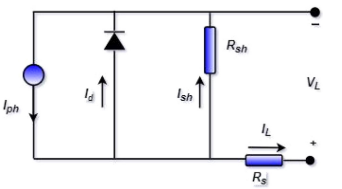


## Librerias

In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd

## Datos

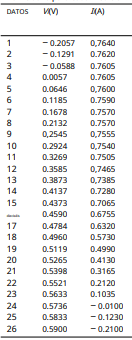

In [ ]:
VL =jnp.array([ -0.2057,-0.1291,-0.0588,0.0057,0.0646,0.1185, 0.1678, 0.2132,   0.2545,  0.2924, 0.3269, 0.3585, 0.3873, 0.4137,0.4373,0.4590, 0.4784,  0.4960,  0.5119, 0.5265, 0.5398,0.5521,0.5633,0.5736,0.5833, 0.5900])
IL =jnp.array([ 0.7640, 0.7620,0.7605, 0.7605, 0.7600,0.7590  , 0.7570, 0.7570  , 0.7555  , 0.7540, 0.7505, 0.7465, 0.7385, 0.7280 , 0.7065, 0.6755, 0.6320 , 0.5730 , 0.4990, 0.4130, 0.3165, 0.2120, 0.1035, -0.0100, -0.1230, -0.2100  ])

## Constantes

In [ ]:
lb=jnp.array([0.0,0.0,0.0,0.0,1.0])
ub=jnp.array([1.0,0.5,100.0,1.0,2.0])
bestParams = jnp.array([0.76077551, 0.0363771, 53.71867407, 0.32302031, 1.48110808])
T = 33
N = 26
k = 1.38064852e-23  #Constante de Boltzmann en [J/(m^2*K)]
T = T + 273.15      #grados convertidos a Kelvin
q = 1.60217657e-19  #Carga del electron en [C]
Vt = (k*T)/q        #Constante para ecuaciones
mu = 10

## Funcion Objetivo

Funcion del modelo de panel solar de diodo unico (SD)

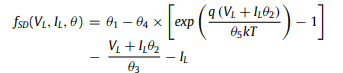


La función objetivo basada en el error cuadrático medio (RMSE)

y se define en función del error entre la corriente medida y la corriente obtenida calculada eslo que se va a minizar en el proceso de optimizacion.

 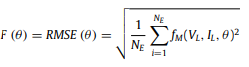

In [ ]:
def Panel(params, VL, IL):
  VLpIL = VL + params[1]*IL
  expTerm = VLpIL/Vt
  res = params[0]-params[3]*(1e-6)*(jnp.exp(expTerm/params[4])-1.0)-VLpIL/params[2]-IL
  return res

def RMSE(params, VL, IL):
  return jnp.sqrt(jnp.mean(jnp.square(Panel(params,VL,IL))))

## Restricciones
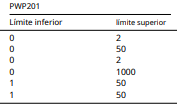

In [ ]:
def cons(params): #retorna la evaluacion de las restricciones
  c1 = -params+lb
  c2 = params-ub
  return jnp.concatenate((c1,c2))

## Metodo QPM

Penalizacion cuadratica combina el RMSE y las restricciones. con el fin de minimizar

In [ ]:
def Q(params,u):
    return RMSE(params,VL,IL)+1.0/(2.0*u)*jnp.sum(jnp.square(jnp.max(jnp.vstack((cons(params),jnp.zeros((10,)))),axis=0)))

In [ ]:
def QPM(x0, u):
    res = optimize.minimize(Q, x0, args= (u,), method = 'BFGS')
    return res.x, res.fun

Se analiza los x0 dentro de limites, hasta que se cumplan las restricciones, se actualiza mu, se encuentra un nuevo minimo xmin y se evalua si se cumplen las restricciones.

In [ ]:
import time
start_time = time.time()
key = jax.random.PRNGKey(0)

x0 = (ub-lb)*jax.random.uniform(key,(5,)) + lb
f0 = Q(x0,mu)
vol = 1e-15
rest_viol = True

it = 0


while rest_viol:
    it=it+1
    xmin, fun = QPM(x0,mu)

    if jnp.all(cons(xmin) <=vol):
      rest_viol = False

    if (fun>f0) or jnp.isnan(fun):
      xmin = x0.copy()
      fun = f0.copy()
      rest_viol = False
    # Actualizacion parametros mu, x0, f0
    mu = mu/2
    x0 = xmin.copy()
    f0 = fun.copy()

print(f'La solucion es: {xmin} en {it} iteracion(es) con un valor RMSE de {fun}')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El programa se ejecuto en {elapsed_time} segundos.")

La solucion es: [7.6393008e-01 3.0600678e-02 3.9315647e+01 9.9733514e-01 1.6052535e+00] en 1 iteracion(es) con un valor RMSE de 0.0036542678717523813
El programa se ejecutó en 1.6567652225494385 segundos.


## Grafica de resultados

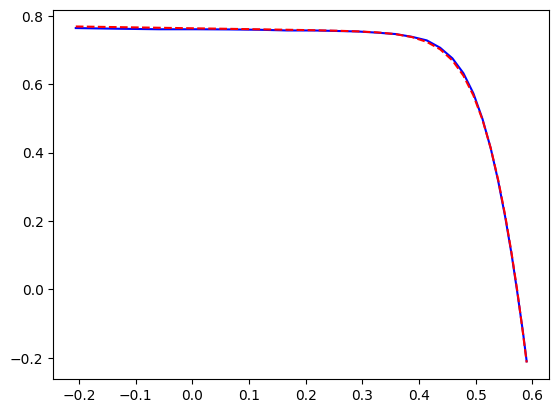

In [ ]:
pred = Panel(xmin,VL,IL)+IL
plt.plot(VL,IL,'b')
plt.plot(VL,pred,'r--')
plt.show()

### Comparacion de resultados con el articulo

 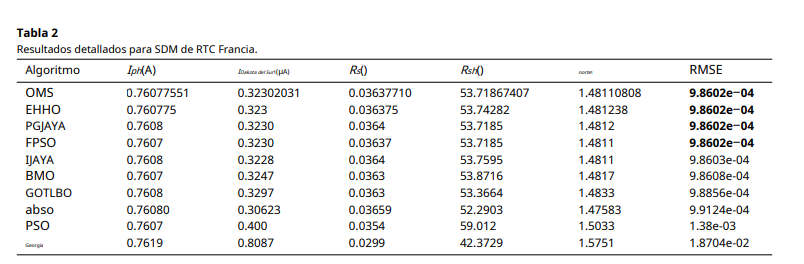

In [ ]:
print(f'''RMSE = {RMSE(xmin,VL,IL)}
RMSE artiiculo = {RMSE(bestParams,VL,IL)}
Diff = {RMSE(xmin,VL,IL)-RMSE(bestParams,VL,IL)}''')

RMSE = 0.0036542711313813925
RMSE artiiculo = 0.0010239144321531057
Diff = 0.0026303566992282867


## Metodo LBM

In [ ]:
import scipy.optimize as sp

La penalizacion se encarga de mantener la solución dentro de los limites permitidos.

In [ ]:
def Q_2(params, u):
    return RMSE(params, VL, IL) - u * jnp.sum(jnp.log(-cons(params)))

### Bounds para la libreria Scipy

se genera los limites para los parametros (θ)

In [ ]:
def generate_bounds():
  pares_tuplas = []
  for i in range(len(lb)):
    tupla = ((lb+1e-6).tolist()[i], (ub-1e-6).tolist()[i])
    pares_tuplas.append(tupla)
  return pares_tuplas

se utiliza el metodo de optimizacion L-BFGS-B de sciPy para minimizar la funcion Q_2

In [ ]:
def LBM(x0, u):
    res = sp.minimize(Q_2, x0, args= (u,), method = 'L-BFGS-B', bounds=generate_bounds())
    return res.x, res.fun

 se ajustar el parametro mu hasta que se satisfacen las restricciones.

In [ ]:
start2_time = time.time()
key = jax.random.PRNGKey(0)
mu = 1e-6

x0 = (ub-lb)*jax.random.uniform(key,(5,)) + lb
f0 = Q_2(x0,mu)
vol = 1e-15
rest_viol = True

it = 0

while rest_viol:
    it=it+1
    xmin_2, fun = LBM(x0,mu)

    if jnp.all(cons(xmin_2) <=vol):
      rest_viol = False

    if (fun>f0) or jnp.isnan(fun):
      xmin_2 = x0.copy()
      fun = f0.copy()
      rest_viol = False
    # Actualizacion parametros mu, x0, f0
    mu = mu/2
    x0 = xmin_2.copy()
    f0 = fun
print(f'La solucion es: {xmin_2} en {it} iteracion(es) con un valor RMSE de {fun}')
end_time2 = time.time()
elapsed_time2 = end_time2 - start2_time
print(f"El programa se ejecuto en {elapsed_time2} segundos.")

La solucion es: [5.74500442e-01 9.96940266e-03 3.93160210e+01 8.94178271e-01
 1.59656656e+00] en 1 iteracion(es) con un valor RMSE de 0.17608016729354858
El programa se ejecuto en 0.02958083152770996 segundos.


In [ ]:
# diferencias enter las soluciones
print(f'''Las soluciones cob ambos metodos son:
    {xmin}
    {xmin_2}
La diferencia entre ambas soluciones es: {abs(xmin - xmin_2)}''')

Las soluciones cob ambos metodos son:
    [7.6559418e-01 3.0513678e-02 3.9315792e+01 9.5140320e-01 1.5992030e+00]
    [5.74500442e-01 9.96940266e-03 3.93160210e+01 8.94178271e-01
 1.59656656e+00]
La diferencia entre ambas soluciones es: [0.19109374 0.02054428 0.00022888 0.05722493 0.00263643]


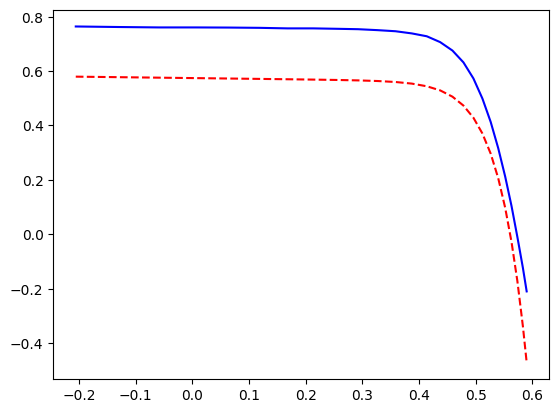

In [ ]:
pred = Panel(xmin_2,VL,IL)+IL
plt.plot(VL,IL,'b')
plt.plot(VL,pred,'r--')
plt.show()

**Concluciones**

-  Al compararlos los parametros obtenidos de cada metodo, para el metedodo QPM se obtuvieron datos mas relacionados con los resultados del articulo
- Cabe mencionar que entre mas parametros desconocidos (θ) , aumenta su
precision y complejida
- Al ejecutar los dos metodos se observa que el metodo de log barrier ejecuta mas rapido.
- Cuanto mas precisos se estime  los
  parametros desconocidos (θ) del modelo fotovoltaico, mejor será el rendimiento y el control del sistema fotovoltaico.

- El modelo del diodo unico es muy utilizado gracias a simpicidad

